In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

%pip install ahrs
from ahrs.filters.madgwick import Madgwick
from ahrs.filters.mahony import Mahony
from ahrs.filters import EKF
from ahrs.common.orientation import acc2q

file_path = '/home/asp/Downloads/AML/final-project/a000_1/data.hdf5'

Note: you may need to restart the kernel to use updated packages.


CONTENTS OF HDF5 FILE:
pose
	 ekf_ori
		 
	 tango_ori
		 
	 tango_pos
		 
raw
	 imu
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, wifi_address, wifi_values
	 tango
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, tango_adf_pose, tango_pose, wifi_address, wifi_values
synced
	 acce
		 
	 game_rv
		 
	 grav
		 
	 gyro
		 
	 gyro_uncalib
		 
	 linacce
		 
	 magnet
		 
	 rv
		 
	 time
		 
(67610, 4)
(67610, 3)
(67610, 3)
(67610, 3)
0.005000000001018634


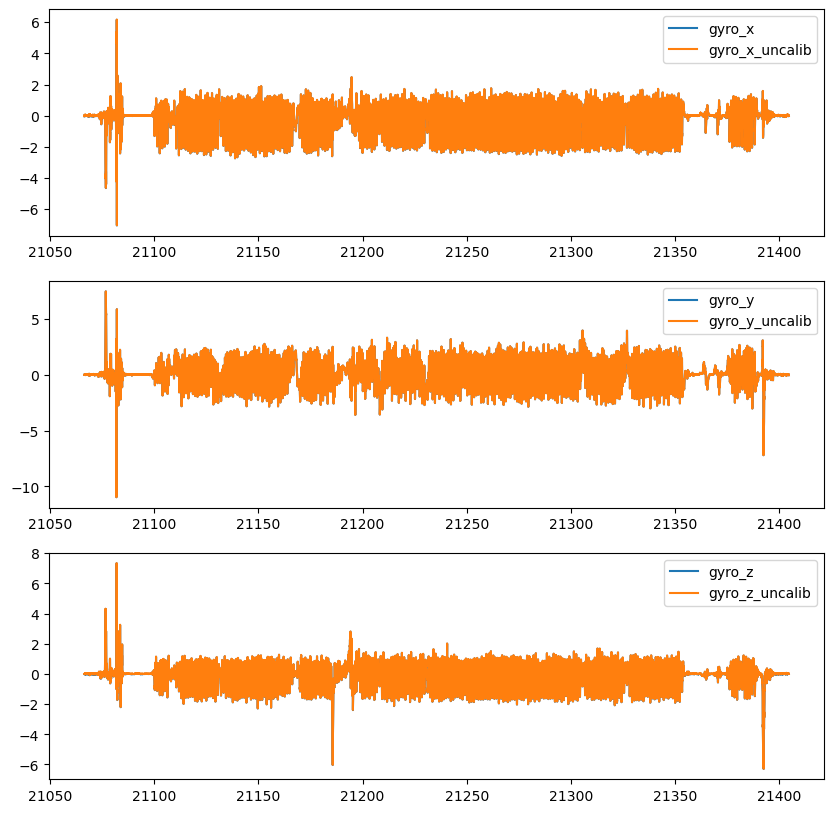

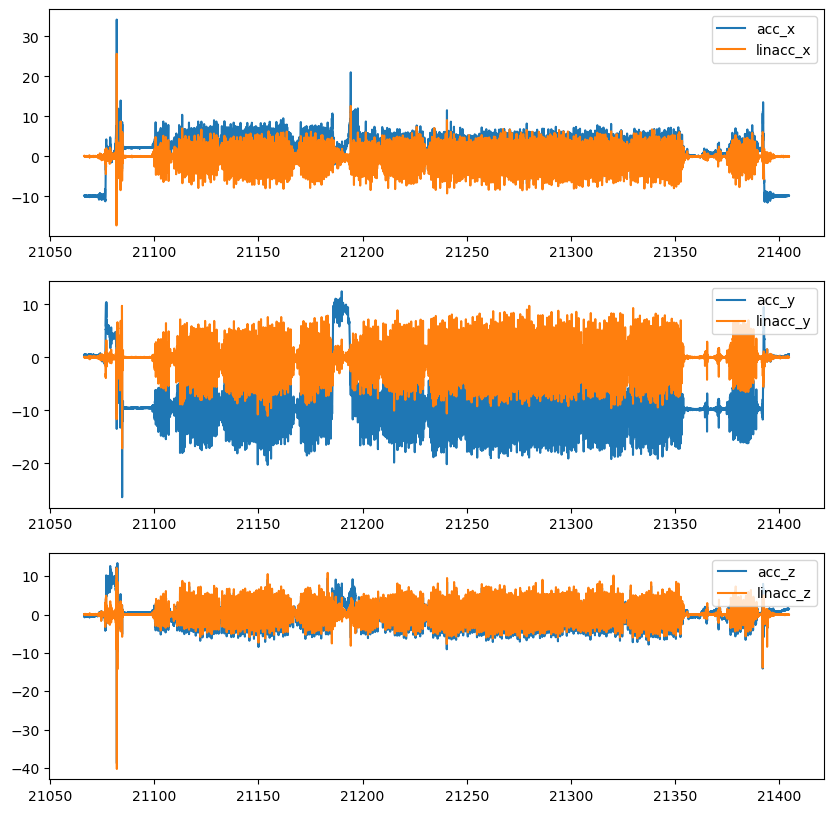

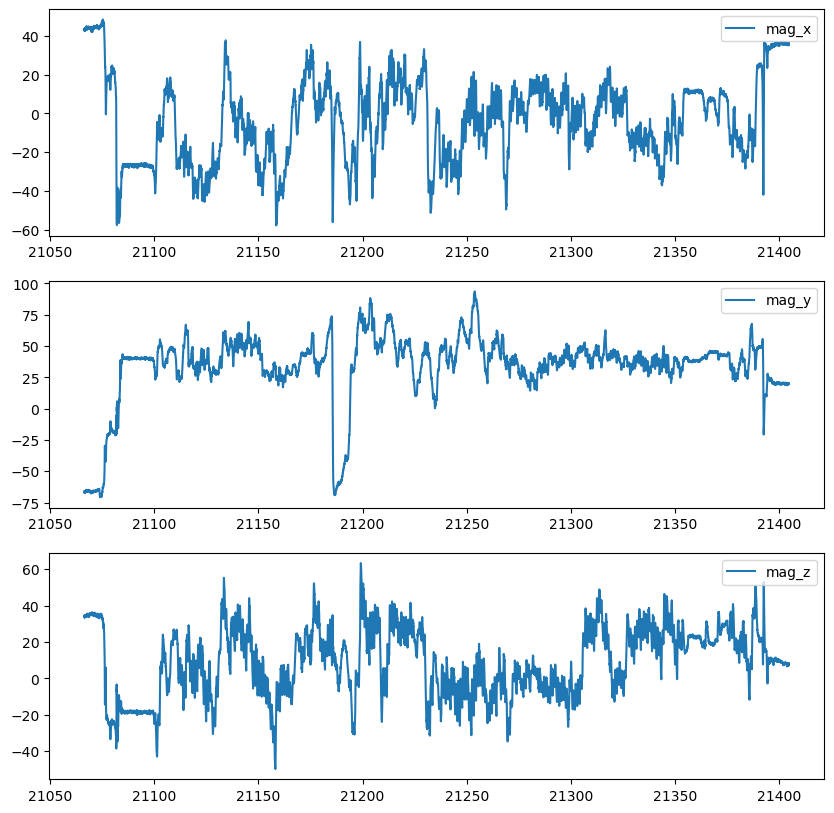

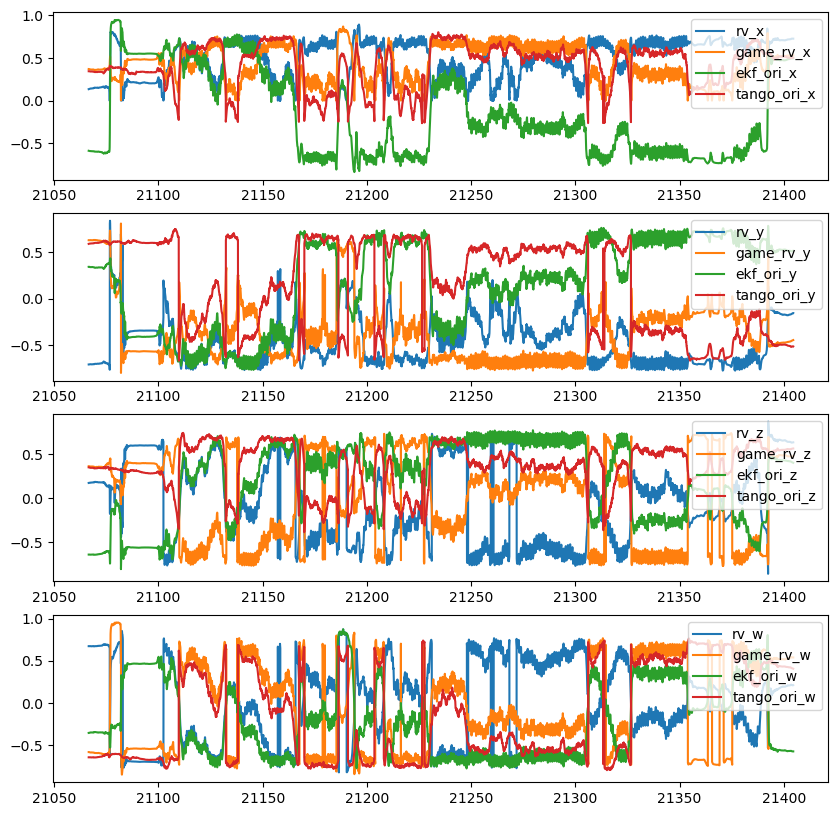

[[-0.58998861  0.34360228 -0.64045332 -0.35166889]
 [-0.59000489  0.34365697 -0.64037418 -0.35173225]
 [-0.59002656  0.34370817 -0.64030011 -0.35178073]
 [-0.59004359  0.34375303 -0.64024558 -0.35180759]
 [-0.5900534   0.34380467 -0.64020469 -0.35181509]
 [-0.59006233  0.34385341 -0.64017243 -0.35181116]
 [-0.59007331  0.34389617 -0.64014876 -0.35179401]
 [-0.59007952  0.34393793 -0.64013661 -0.35176487]
 [-0.59008221  0.34397062 -0.640142   -0.35171859]
 [-0.59009285  0.34399298 -0.64015047 -0.35166346]]


In [3]:
if '..' not in sys.path:
    sys.path.append('../')
from utils import load_data
data_dict = load_data(file_path, verbose=True)

N = 0

if N == 0:
    ekf_ori = data_dict['pose/ekf_ori']
    tango_ori = data_dict['pose/tango_ori']
    gyro = data_dict['synced/gyro']
    gyro_uncalib = data_dict['synced/gyro_uncalib']
    acc = data_dict['synced/acce']
    linacc = data_dict['synced/linacce']
    mag = data_dict['synced/magnet']
    num_samples = ekf_ori.shape[0]
    time = data_dict['synced/time']
    rv = data_dict['synced/rv']
    game_rv = data_dict['synced/game_rv']
    diffs = np.diff(time)
    dt = np.mean(diffs)
    q_0 = ekf_ori[0,:]
    
else:
    ekf_ori = data_dict['pose/ekf_ori'][:N]
    tango_ori = data_dict['pose/tango_ori'][:N]
    gyro = data_dict['synced/gyro'][:N]
    gyro_uncalib = data_dict['synced/gyro_uncalib'][:N]
    acc = data_dict['synced/acce'][:N]
    linacc = data_dict['synced/linacce'][:N]
    mag = data_dict['synced/magnet'][:N]
    num_samples = ekf_ori.shape[0]
    time = data_dict['synced/time'][:N]
    rv = data_dict['synced/rv'][:N]
    game_rv = data_dict['synced/game_rv'][:N]
    diffs = np.diff(time)
    dt = np.mean(diffs)
    q_0 = ekf_ori[0,:]

print(ekf_ori.shape)
print(gyro.shape)
print(acc.shape)
print(mag.shape)
print(dt)

fig, ax = plt.subplots(3,1, figsize=(10,10))
ax[0].plot(time, gyro[:,0], label='gyro_x')
ax[0].plot(time, gyro_uncalib[:,0], label='gyro_x_uncalib')
ax[0].legend(loc = 'upper right')
ax[1].plot(time, gyro[:,1], label='gyro_y')
ax[1].plot(time, gyro_uncalib[:,1], label='gyro_y_uncalib')
ax[1].legend(loc = 'upper right')
ax[2].plot(time, gyro[:,2], label='gyro_z')
ax[2].plot(time, gyro_uncalib[:,2], label='gyro_z_uncalib')
ax[2].legend(loc = 'upper right')
plt.show()


fig, ax = plt.subplots(3,1, figsize=(10,10))
ax[0].plot(time, acc[:,0], label='acc_x')
ax[0].plot(time, linacc[:,0], label='linacc_x')
ax[0].legend(loc = 'upper right')
ax[1].plot(time, acc[:,1], label='acc_y')
ax[1].plot(time, linacc[:,1], label='linacc_y')
ax[1].legend(loc = 'upper right')
ax[2].plot(time, acc[:,2], label='acc_z')
ax[2].plot(time, linacc[:,2], label='linacc_z')
ax[2].legend(loc = 'upper right')
plt.show()

fig, ax = plt.subplots(3,1, figsize=(10,10))
ax[0].plot(time, mag[:,0], label='mag_x')
ax[0].legend()
ax[1].plot(time, mag[:,1], label='mag_y')
ax[1].legend()
ax[2].plot(time, mag[:,2], label='mag_z')
ax[2].legend(loc = 'upper right')
plt.show()

fig, ax = plt.subplots(4,1, figsize=(10,10))
ax[0].plot(time, rv[:,0], label='rv_x')
ax[0].plot(time, game_rv[:,0], label='game_rv_x')
ax[0].plot(time, ekf_ori[:,0], label='ekf_ori_x')
ax[0].plot(time, tango_ori[:,0], label='tango_ori_x')
ax[0].legend(loc = 'upper right')
ax[1].plot(time, rv[:,1], label='rv_y')
ax[1].plot(time, game_rv[:,1], label='game_rv_y')
ax[1].plot(time, ekf_ori[:,1], label='ekf_ori_y')
ax[1].plot(time, tango_ori[:,1], label='tango_ori_y')
ax[1].legend(loc = 'upper right')
ax[2].plot(time, rv[:,2], label='rv_z')
ax[2].plot(time, game_rv[:,2], label='game_rv_z')
ax[2].plot(time, ekf_ori[:,2], label='ekf_ori_z')
ax[2].plot(time, tango_ori[:,2], label='tango_ori_z')
ax[2].legend(loc = 'upper right')
ax[3].plot(time, rv[:,3], label='rv_w')
ax[3].plot(time, game_rv[:,3], label='game_rv_w')
ax[3].plot(time, ekf_ori[:,3], label='ekf_ori_w')
ax[3].plot(time, tango_ori[:,3], label='tango_ori_w')
ax[3].legend(loc = 'upper right')
plt.show()

print(ekf_ori[:10,:])

## Find Ideal Parameters

In [4]:
# from ahrs.utils.metrics import qdist, qcip

# def madgwick_cost(params):
#     gain = params[0]
#     madgwick_filter = Madgwick(gyr = gyro, acc = acc, mag=mag, dt = dt, q0 = q_0, 
#                                gain = gain)
#     Q_1 = madgwick_filter.Q
#     print(np.linalg.norm(qcip(Q_1, ekf_ori)))
#     return np.linalg.norm(qcip(Q_1, ekf_ori))

# def mahony_cost(params):
#     k_P, k_I = params
#     mahony_filter = Mahony(gyr = gyro, acc = acc, mag=mag, dt = dt, q0 = q_0,
#                            k_P = k_P, k_I = k_I)
#     Q_2 = mahony_filter.Q
#     return np.linalg.norm(qcip(Q_2, ekf_ori))

# def ekf_cost(params):
#     gyro_var, acc_var, mag_var = params**2
#     ekf = EKF(gyr = gyro, acc = acc, mag=mag, dt = dt, q0=q_0, 
#               gyro_var = gyro_var, acc_var = acc_var, mag_var=mag_var)
#     Q_ekf = ekf.Q
#     return np.linalg.norm(qcip(Q_ekf, ekf_ori))

# # Initial guess
# init_guess_madgwick = [0.033]
# init_guess_mahony = [1.0, 0.3]
# init_guess_ekf = [0.3, 0.5, 0.8]
# bounds_ekf = [(0, None), (0, None), (0, None)]

# # Optimization for Madgwick
# madgwick_result = minimize(madgwick_cost, init_guess_madgwick)
# optimal_gain = madgwick_result.x
# print("Optimized Gain for Madgwick Filter: ", optimal_gain)

# # Optimization for Mahony
# mahony_result = minimize(mahony_cost, init_guess_mahony)
# optimal_k_P, optimal_k_I = mahony_result.x
# print("Optimized k_P and k_I for Mahony Filter: ", optimal_k_P, optimal_k_I)

# # # Optimization for EKF
# # ekf_result = minimize(ekf_cost, init_guess_ekf, bounds=bounds_ekf)
# # optimal_gyro_var, optimal_acc_var, optimal_mag_var = ekf_result.x
# # print("Optimized gyro_var and acc_var for EKF: ", optimal_gyro_var, optimal_acc_var, optimal_mag_var)

In [5]:
# Optimized Gain for Madgwick Filter:  [1.04299724]
# Optimized k_P and k_I for Mahony Filter:  0.8311948880973625 0.13119070597985183
# Optimized gyro_var and acc_var for EKF:  0.3 0.5 0.8


gain = 1.04299724
madgwick_filter = Madgwick(gyr = gyro, acc = acc, mag=mag, dt = dt, q0=q_0, gain=gain)
Q_1 = madgwick_filter.Q


k_P = 0.8311948880973625
k_I = 0.13119070597985183
mahony_filter = Mahony(gyr = gyro, acc = acc, mag=mag, dt = dt, q0=q_0, k_P=k_P, k_I=k_I)
Q_2 = mahony_filter.Q


acc_var = 0.3**2
gyro_var = 0.5**2
mag_var = 0.8**2
ekf = EKF(gyr=gyro, acc=acc, mag=mag, dt = dt, q0=q_0, noises= [gyro_var, acc_var, mag_var])
Q_ekf = ekf.Q

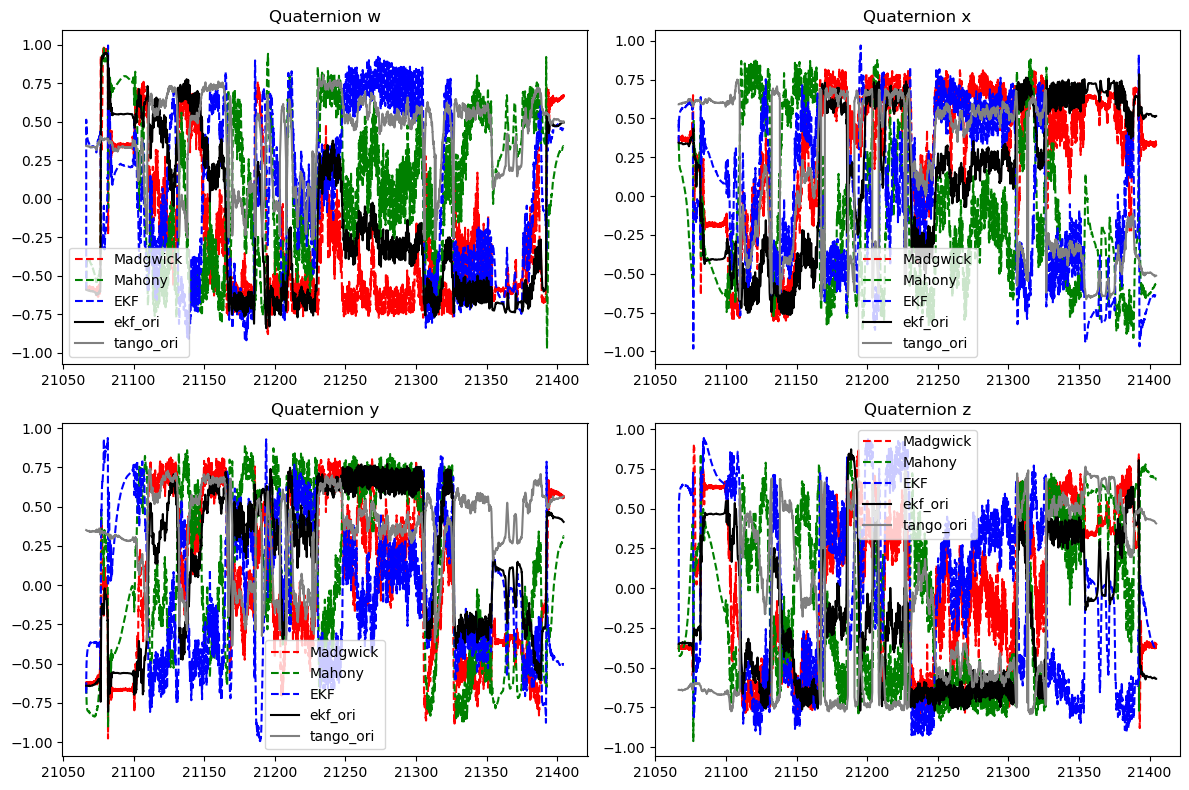

In [6]:
end = time[-1]
start = time[0]
t = np.linspace(start, end+dt, num_samples)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Quaternion w
axs[0, 0].plot(t, Q_1[:, 0], label='Madgwick', color='red', linestyle='dashed')
axs[0, 0].plot(t, Q_2[:, 0], label='Mahony', color='green', linestyle='dashed')
axs[0, 0].plot(t, Q_ekf[:, 0], label='EKF', color='blue', linestyle='dashed')
axs[0, 0].plot(t, ekf_ori[:, 0], label='ekf_ori', color='black')
axs[0, 0].plot(t, tango_ori[:, 0], label='tango_ori', color='gray')
axs[0, 0].set_title('Quaternion w')
axs[0, 0].legend()

# Quaternion x
axs[0, 1].plot(t, Q_1[:, 1], label='Madgwick', color='red', linestyle='dashed')
axs[0, 1].plot(t, Q_2[:, 1], label='Mahony', color='green', linestyle='dashed')
axs[0, 1].plot(t, Q_ekf[:, 1], label='EKF', color='blue', linestyle='dashed')
axs[0, 1].plot(t, ekf_ori[:, 1], label='ekf_ori', color='black')
axs[0, 1].plot(t, tango_ori[:, 1], label='tango_ori', color='gray')
axs[0, 1].set_title('Quaternion x')
axs[0, 1].legend()

# Quaternion y
axs[1, 0].plot(t, Q_1[:, 2], label='Madgwick', color='red', linestyle='dashed')
axs[1, 0].plot(t, Q_2[:, 2], label='Mahony', color='green', linestyle='dashed')
axs[1, 0].plot(t, Q_ekf[:, 2], label='EKF', color='blue', linestyle='dashed')
axs[1, 0].plot(t, ekf_ori[:, 2], label='ekf_ori', color='black')
axs[1, 0].plot(t, tango_ori[:, 2], label='tango_ori', color='gray')
axs[1, 0].set_title('Quaternion y')
axs[1, 0].legend()

# Quaternion z
axs[1, 1].plot(t, Q_1[:, 3], label='Madgwick', color='red', linestyle='dashed')
axs[1, 1].plot(t, Q_2[:, 3], label='Mahony', color='green', linestyle='dashed')
axs[1, 1].plot(t, Q_ekf[:, 3], label='EKF', color='blue', linestyle='dashed')
axs[1, 1].plot(t, ekf_ori[:, 3], label='ekf_ori', color='black')
axs[1, 1].plot(t, tango_ori[:, 3], label='tango_ori', color='gray')
axs[1, 1].set_title('Quaternion z')
axs[1, 1].legend()

# Display the plot
plt.tight_layout()
plt.show()


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import random_split

# Check if the data is already a Tensor, if not convert it
if not torch.is_tensor(gyro):
    gyro = torch.from_numpy(gyro).float()
if not torch.is_tensor(acc):
    acc = torch.from_numpy(acc).float()
if not torch.is_tensor(mag):
    mag = torch.from_numpy(mag).float()
if not torch.is_tensor(rv):
    rv = torch.from_numpy(rv).float()
if not torch.is_tensor(game_rv):
    game_rv = torch.from_numpy(game_rv).float()
if not torch.is_tensor(Q_1):
    Q_1 = torch.from_numpy(Q_1).float()
if not torch.is_tensor(Q_2):
    Q_2 = torch.from_numpy(Q_2).float()
if not torch.is_tensor(Q_ekf):
    Q_ekf = torch.from_numpy(Q_ekf).float()

## using rv and game_rv

Epoch 1/10, Train Loss: 0.0160, Validation Loss: 0.0073
Epoch 2/10, Train Loss: 0.0053, Validation Loss: 0.0050
Epoch 3/10, Train Loss: 0.0040, Validation Loss: 0.0040
Epoch 4/10, Train Loss: 0.0032, Validation Loss: 0.0034
Epoch 5/10, Train Loss: 0.0027, Validation Loss: 0.0035
Epoch 6/10, Train Loss: 0.0024, Validation Loss: 0.0036
Epoch 7/10, Train Loss: 0.0021, Validation Loss: 0.0037
Epoch 8/10, Train Loss: 0.0020, Validation Loss: 0.0032
Epoch 9/10, Train Loss: 0.0018, Validation Loss: 0.0034
Epoch 10/10, Train Loss: 0.0017, Validation Loss: 0.0030
Finished Training


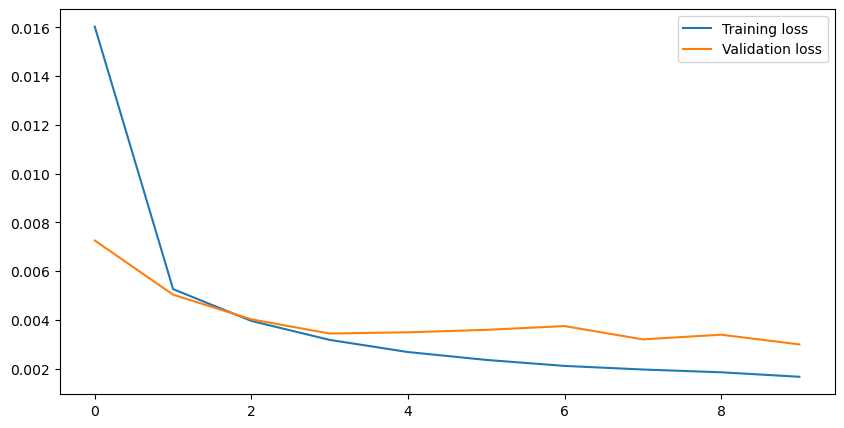

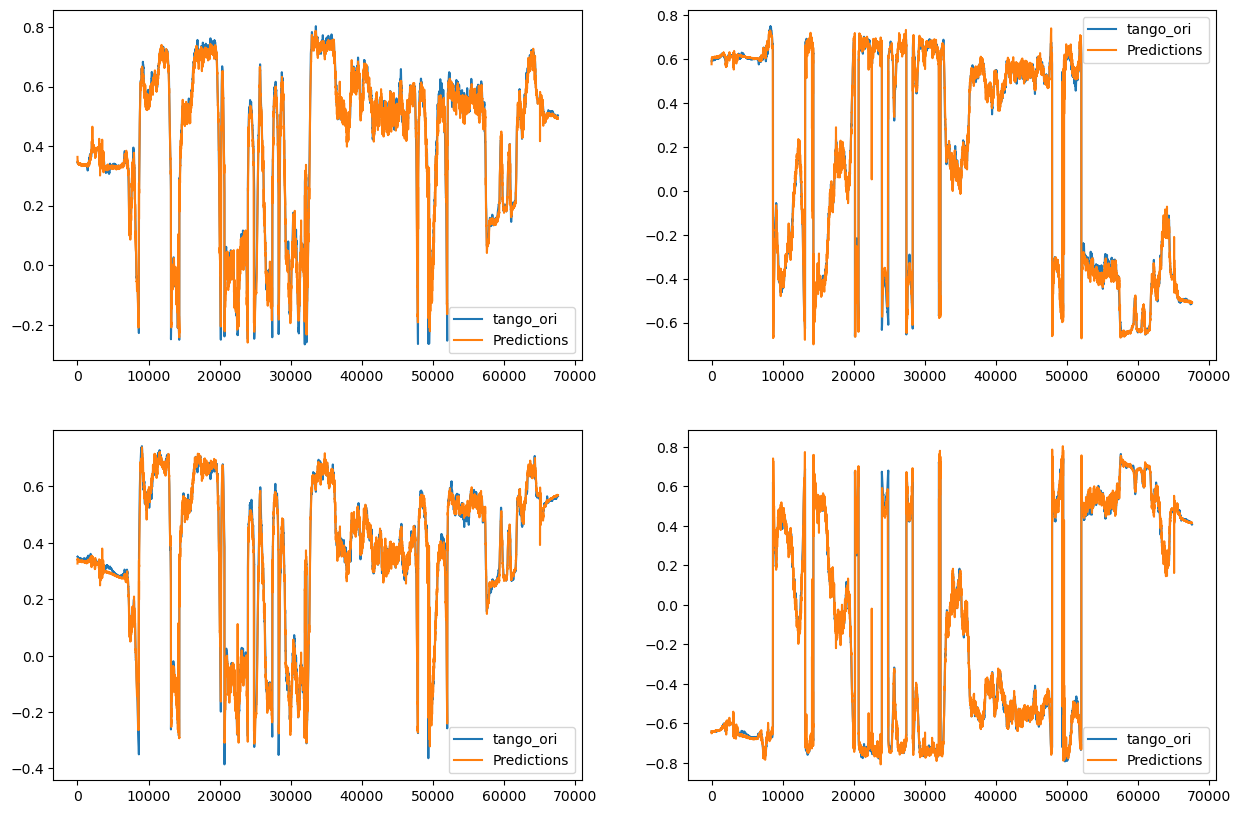

In [8]:
# Stack along the feature dimension
train_data = torch.cat((gyro, acc, mag, rv, game_rv, Q_1, Q_2, Q_ekf), dim=1)

# Your new input_size is the number of features in your data
input_size = train_data.shape[1]

# Assume you have your target tensor
if not torch.is_tensor(tango_ori):
    tango_ori = torch.from_numpy(tango_ori).float()

# Defining the LSTM model
class LSTMOrientation(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMOrientation, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :]) # only take the last time step
        
        return out

# Hyperparameters
input_size = 29 # input size to match your data
hidden_size = 64 
num_layers = 2
output_size = 4 # output size to match your data
num_epochs = 10
learning_rate = 0.001

# Replace the random tensors with your actual data
train_data = train_data.view(num_samples, -1, input_size)  # Reshape to (num_samples, seq_len, input_size)
train_labels = tango_ori

# Splitting ratio for train and validation set
train_size = int(0.8 * num_samples)  # 80% for training
val_size = num_samples - train_size  # 20% for validation

# Create TensorDataset
full_dataset = torch.utils.data.TensorDataset(train_data, train_labels)

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoader for both train_dataset and val_dataset
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=input_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=input_size, shuffle=False)

# Initialize the model, loss function and optimizer
model = LSTMOrientation(input_size, hidden_size, num_layers, output_size)
model.to('cpu') # Change to 'cuda' if you have a GPU available

criterion = nn.MSELoss() # Modify if you have a different target
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to save the losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_epoch_losses = []
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to('cpu')  # Change to 'cuda' if you have a GPU available
        labels = labels.to('cpu')  # Change to 'cuda' if you have a GPU available

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_epoch_losses.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(np.mean(train_epoch_losses))
    
    model.eval()
    val_epoch_losses = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to('cpu')  # Change to 'cuda' if you have a GPU available
            labels = labels.to('cpu')  # Change to 'cuda' if you have a GPU available

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_epoch_losses.append(loss.item())

    val_losses.append(np.mean(val_epoch_losses))

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

print("Finished Training")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

# To make predictions, you can do
model.eval()
with torch.no_grad():
    predictions = model(train_data.to('cpu'))  # Change to 'cuda' if you have a GPU available

# And now you can plot a comparison between tango_ori and predictions
# Assume tango_ori and predictions are of shape (num_samples, 4)
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for i in range(4):
    ax[i//2, i%2].plot(tango_ori[:, i], label='tango_ori')
    ax[i//2, i%2].plot(predictions[:, i], label='Predictions')
    ax[i//2, i%2].legend()

plt.show()

## without rv and game_rv

Epoch 1/10, Train Loss: 0.0173, Validation Loss: 0.0075
Epoch 2/10, Train Loss: 0.0068, Validation Loss: 0.0050
Epoch 3/10, Train Loss: 0.0050, Validation Loss: 0.0042
Epoch 4/10, Train Loss: 0.0040, Validation Loss: 0.0037
Epoch 5/10, Train Loss: 0.0033, Validation Loss: 0.0031
Epoch 6/10, Train Loss: 0.0029, Validation Loss: 0.0025
Epoch 7/10, Train Loss: 0.0025, Validation Loss: 0.0021
Epoch 8/10, Train Loss: 0.0023, Validation Loss: 0.0021
Epoch 9/10, Train Loss: 0.0022, Validation Loss: 0.0017
Epoch 10/10, Train Loss: 0.0020, Validation Loss: 0.0014
Finished Training


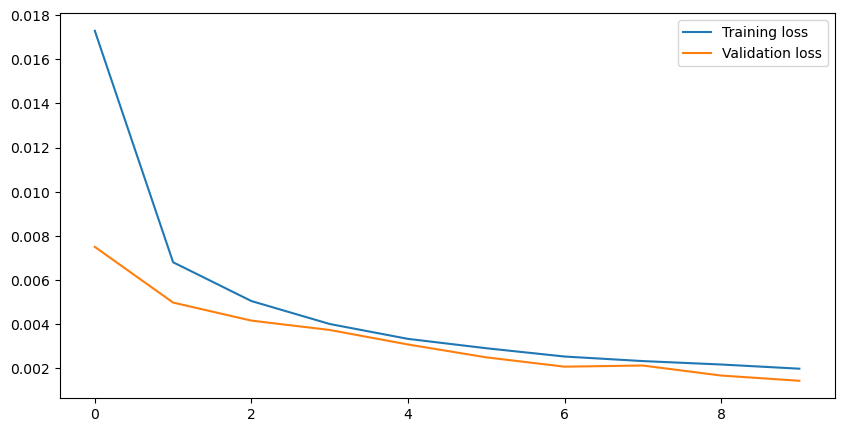

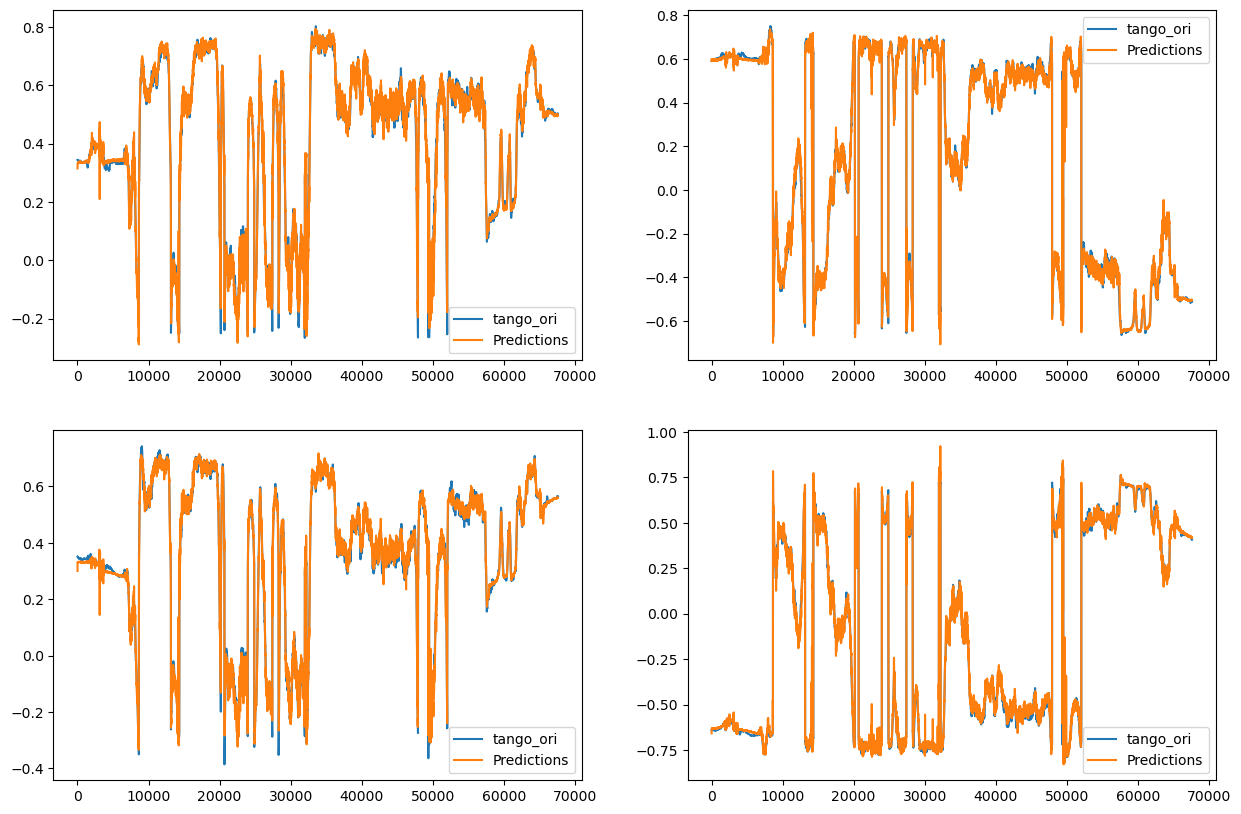

In [9]:
# Stack along the feature dimension
train_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf), dim=1)

# Your new input_size is the number of features in your data
input_size = train_data.shape[1]

# Assume you have your target tensor
if not torch.is_tensor(tango_ori):
    tango_ori = torch.from_numpy(tango_ori).float()

# Defining the LSTM model
class LSTMOrientation(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMOrientation, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :]) # only take the last time step
        
        return out

# Hyperparameters
input_size = 21 # input size to match your data
hidden_size = 64 
num_layers = 2
output_size = 4 # output size to match your data
num_epochs = 10
learning_rate = 0.001

# Replace the random tensors with your actual data
train_data = train_data.view(num_samples, -1, input_size)  # Reshape to (num_samples, seq_len, input_size)
train_labels = tango_ori

# Splitting ratio for train and validation set
train_size = int(0.8 * num_samples)  # 80% for training
val_size = num_samples - train_size  # 20% for validation

# Create TensorDataset
full_dataset = torch.utils.data.TensorDataset(train_data, train_labels)

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoader for both train_dataset and val_dataset
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=input_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=input_size, shuffle=False)

# Initialize the model, loss function and optimizer
model = LSTMOrientation(input_size, hidden_size, num_layers, output_size)
model.to('cpu') # Change to 'cuda' if you have a GPU available

criterion = nn.MSELoss() # Modify if you have a different target
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to save the losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_epoch_losses = []
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to('cpu')  # Change to 'cuda' if you have a GPU available
        labels = labels.to('cpu')  # Change to 'cuda' if you have a GPU available

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_epoch_losses.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(np.mean(train_epoch_losses))
    
    model.eval()
    val_epoch_losses = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to('cpu')  # Change to 'cuda' if you have a GPU available
            labels = labels.to('cpu')  # Change to 'cuda' if you have a GPU available

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_epoch_losses.append(loss.item())

    val_losses.append(np.mean(val_epoch_losses))

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

print("Finished Training")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

# To make predictions, you can do
model.eval()
with torch.no_grad():
    predictions = model(train_data.to('cpu'))  # Change to 'cuda' if you have a GPU available

# And now you can plot a comparison between tango_ori and predictions
# Assume tango_ori and predictions are of shape (num_samples, 4)
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for i in range(4):
    ax[i//2, i%2].plot(tango_ori[:, i], label='tango_ori')
    ax[i//2, i%2].plot(predictions[:, i], label='Predictions')
    ax[i//2, i%2].legend()

plt.show()

## without filters

Epoch 1/10, Train Loss: 0.0536, Validation Loss: 0.0433
Epoch 2/10, Train Loss: 0.0381, Validation Loss: 0.0362
Epoch 3/10, Train Loss: 0.0326, Validation Loss: 0.0327
Epoch 4/10, Train Loss: 0.0297, Validation Loss: 0.0314
Epoch 5/10, Train Loss: 0.0273, Validation Loss: 0.0278
Epoch 6/10, Train Loss: 0.0251, Validation Loss: 0.0252
Epoch 7/10, Train Loss: 0.0231, Validation Loss: 0.0239
Epoch 8/10, Train Loss: 0.0213, Validation Loss: 0.0219
Epoch 9/10, Train Loss: 0.0197, Validation Loss: 0.0196
Epoch 10/10, Train Loss: 0.0184, Validation Loss: 0.0189
Finished Training


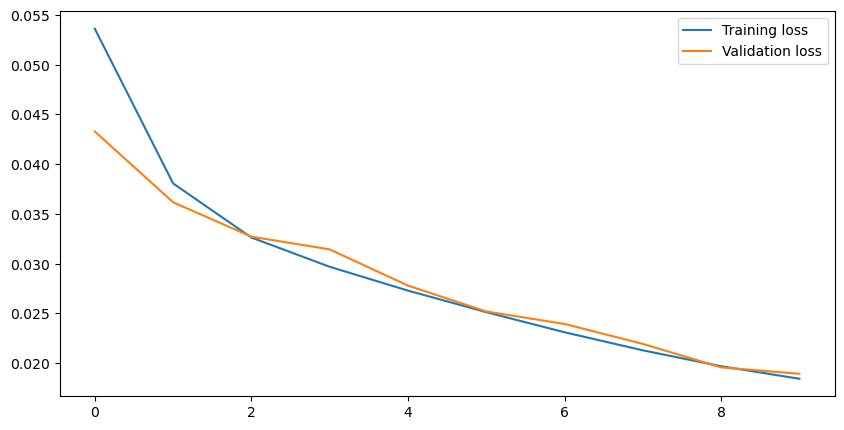

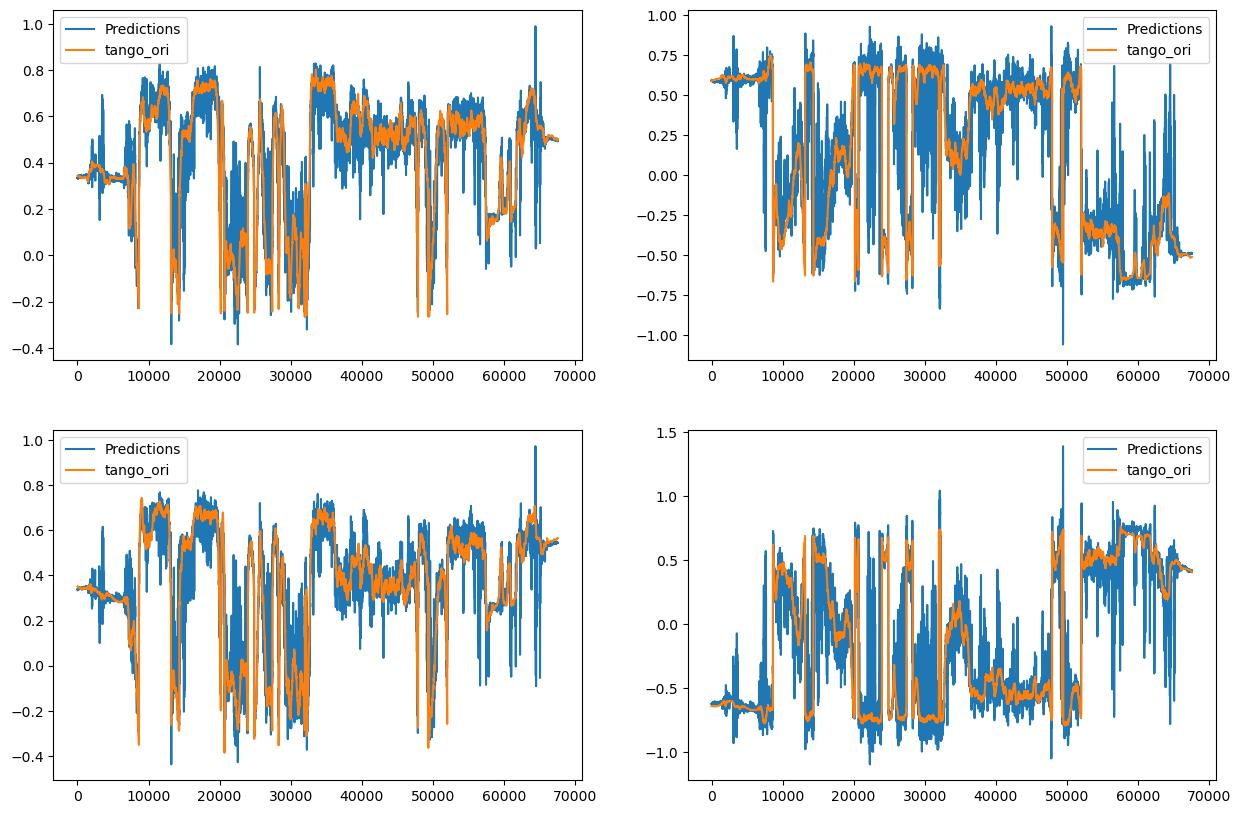

In [10]:
# Stack along the feature dimension
train_data = torch.cat((gyro, acc, mag), dim=1)

# Your new input_size is the number of features in your data
input_size = train_data.shape[1]

# Defining the LSTM model
class LSTMOrientation(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMOrientation, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :]) # only take the last time step
        
        return out

# Hyperparameters
input_size = 9 # input size to match your data
hidden_size = 64 
num_layers = 2
output_size = 4 # output size to match your data
num_epochs = 10
learning_rate = 0.001

# Replace the random tensors with your actual data
train_data = train_data.view(num_samples, -1, input_size)  # Reshape to (num_samples, seq_len, input_size)
train_labels = tango_ori

# Splitting ratio for train and validation set
train_size = int(0.8 * num_samples)  # 80% for training
val_size = num_samples - train_size  # 20% for validation

# Create TensorDataset
full_dataset = torch.utils.data.TensorDataset(train_data, train_labels)

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoader for both train_dataset and val_dataset
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=input_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=input_size, shuffle=False)

# Initialize the model, loss function and optimizer
model = LSTMOrientation(input_size, hidden_size, num_layers, output_size)
model.to('cpu') # Change to 'cuda' if you have a GPU available

criterion = nn.MSELoss() # Modify if you have a different target
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to save the losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_epoch_losses = []
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to('cpu')  # Change to 'cuda' if you have a GPU available
        labels = labels.to('cpu')  # Change to 'cuda' if you have a GPU available

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_epoch_losses.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_losses.append(np.mean(train_epoch_losses))
    
    model.eval()
    val_epoch_losses = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to('cpu')  # Change to 'cuda' if you have a GPU available
            labels = labels.to('cpu')  # Change to 'cuda' if you have a GPU available

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_epoch_losses.append(loss.item())

    val_losses.append(np.mean(val_epoch_losses))

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

print("Finished Training")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

# To make predictions, you can do
model.eval()
with torch.no_grad():
    predictions = model(train_data.to('cpu'))  # Change to 'cuda' if you have a GPU available

# And now you can plot a comparison between tango_ori and predictions
# Assume tango_ori and predictions are of shape (num_samples, 4)
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for i in range(4):
    ax[i//2, i%2].plot(predictions[:, i], label='Predictions')
    ax[i//2, i%2].plot(tango_ori[:, i], label='tango_ori')
    ax[i//2, i%2].legend()

plt.show()

In [16]:
class LSTMOrientation(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMOrientation, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :])
        
        return out

# Hyperparameters
input_size = 21 # input size to match your data
hidden_size = 128
num_layers = 3
output_size = 4 # output size to match your data
num_epochs = 200
learning_rate = 0.001
seq_len = 5

# Stack along the feature dimension
train_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf), dim=1)

# Your new input_size is the number of features in your data
input_size = train_data.shape[1]

# Replace the random tensors with your actual data
train_data = train_data.view(num_samples, -1, input_size)  # Reshape to (num_samples, seq_len, input_size)
train_labels = tango_ori

# Splitting ratio for train and validation set
train_size = 60000

# Split the dataset into training and testing sets
train_data, train_labels = train_data[:train_size], train_labels[:train_size]

# Reshape your data to (num_samples, seq_len, input_size) 
train_data = train_data.view(train_size, -1, input_size)

# Initialize the model, loss function and optimizer
model = LSTMOrientation(input_size, hidden_size, num_layers, output_size)
model.to('cpu') # Change to 'cuda' if you have a GPU available

criterion = nn.MSELoss() # Modify if you have a different target
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    # Forward pass
    outputs = model(train_data)
    loss = criterion(outputs, train_labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}')

print("Finished Training")

# Reconstruct the full dataset after training
full_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf), dim=1)
full_data = full_data.view(num_samples, -1, input_size)

# To make predictions, you can do
model.eval()
with torch.no_grad():
    predictions = model(full_data.to('cpu'))

Epoch 1/200, Train Loss: 0.2227
Epoch 2/200, Train Loss: 0.2178
Epoch 3/200, Train Loss: 0.2130
Epoch 4/200, Train Loss: 0.2082
Epoch 5/200, Train Loss: 0.2033
Epoch 6/200, Train Loss: 0.1981
Epoch 7/200, Train Loss: 0.1926
Epoch 8/200, Train Loss: 0.1867
Epoch 9/200, Train Loss: 0.1803
Epoch 10/200, Train Loss: 0.1735
Epoch 11/200, Train Loss: 0.1663
Epoch 12/200, Train Loss: 0.1589
Epoch 13/200, Train Loss: 0.1516
Epoch 14/200, Train Loss: 0.1450
Epoch 15/200, Train Loss: 0.1395
Epoch 16/200, Train Loss: 0.1358
Epoch 17/200, Train Loss: 0.1337
Epoch 18/200, Train Loss: 0.1323
Epoch 19/200, Train Loss: 0.1301
Epoch 20/200, Train Loss: 0.1261
Epoch 21/200, Train Loss: 0.1207
Epoch 22/200, Train Loss: 0.1146
Epoch 23/200, Train Loss: 0.1086
Epoch 24/200, Train Loss: 0.1032
Epoch 25/200, Train Loss: 0.0986
Epoch 26/200, Train Loss: 0.0947
Epoch 27/200, Train Loss: 0.0914
Epoch 28/200, Train Loss: 0.0887
Epoch 29/200, Train Loss: 0.0865
Epoch 30/200, Train Loss: 0.0850
Epoch 31/200, Train

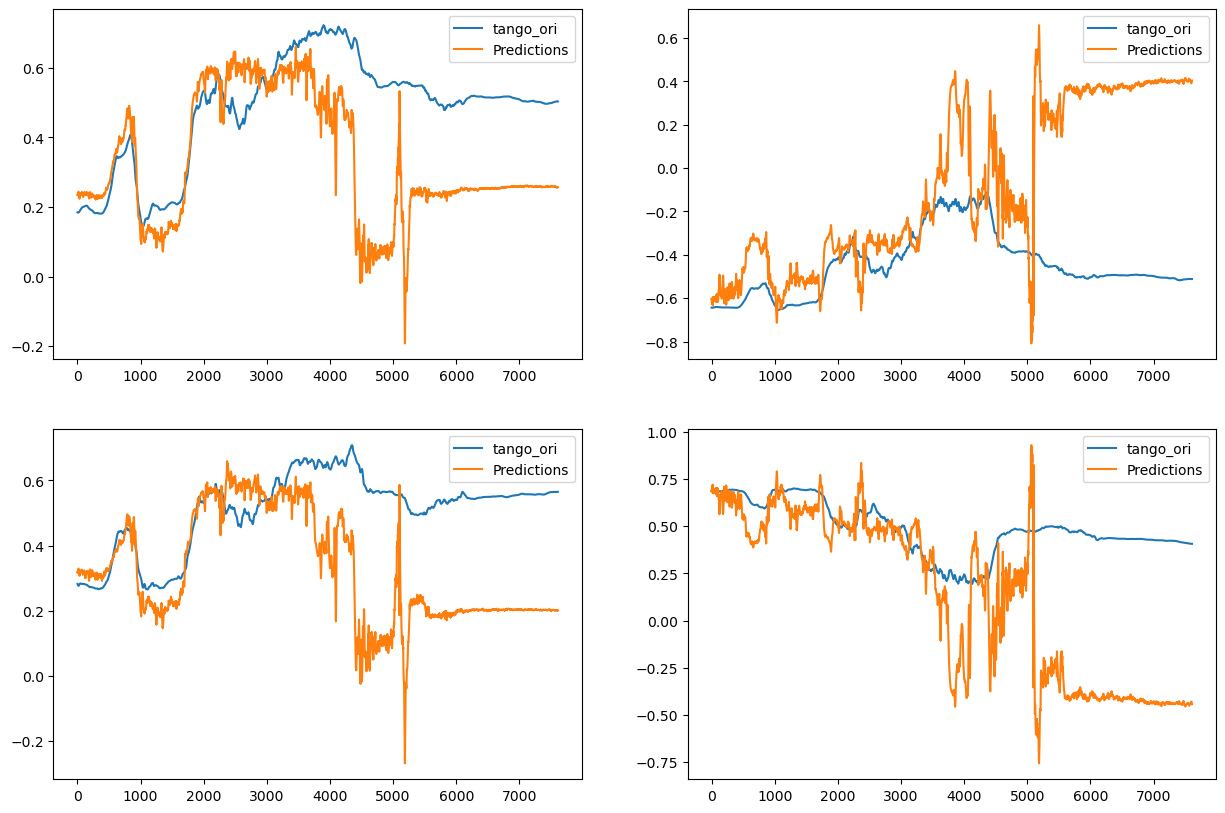

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for i in range(4):
    ax[i//2, i%2].plot(tango_ori[train_size:, i], label='tango_ori')
    ax[i//2, i%2].plot(predictions[train_size:, i], label='Predictions')
    ax[i//2, i%2].legend()

plt.show()